In [338]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import os
from pyclass import TransformSubset, TinyCNN
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np



In [339]:
SEED = 42 

random.seed(SEED)     
np.random.seed(SEED)     
torch.manual_seed(SEED)  
torch.cuda.manual_seed(SEED)     
torch.cuda.manual_seed_all(SEED)   
torch.backends.cudnn.benchmark = False 
torch.backends.cudnn.deterministic = True 

In [340]:
class PLKDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        self.images = data['images']
        self.labels = data['labels'].reshape(-1)
        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = int(self.labels[idx])

  
        
        image = Image.fromarray(image.astype('uint8')) 
        
        if self.transform:
            image = self.transform(image)

        return image, label


In [341]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    use_mps = True
elif torch.cuda.is_available():
    device = torch.device("cpu")
    use_mps = False

print(device)

mps


In [342]:
dataset = PLKDataset('ift-3395-6390-kaggle-2-competition-fall-2025/train_data.pkl')


In [343]:
raw_images, raw_labels = dataset.images, dataset.labels

In [344]:

labels = dataset.labels
idx = np.arange(len(dataset))
train_idx, valid_idx = train_test_split(idx, test_size=0.2, stratify=labels, random_state=42)



In [345]:
X_train_raw = dataset.images[train_idx]

X_train_float =X_train_raw.astype(np.float32) / 255.0

means = X_train_float.mean(axis=(0,1,2))
std = X_train_float.std(axis=(0,1,2))

IR_MEAN = means.tolist()
IR_STD = std.tolist()

print("IR_MEAN=", IR_MEAN)
print("IR_STD=", IR_STD)

IR_MEAN= [0.2111530601978302, 0.005323430523276329, 0.22947929799556732]
IR_STD= [0.18979966640472412, 0.016638699918985367, 0.16980312764644623]


In [346]:
import torch
from torchvision import transforms
import numpy as np

# 1. Custom function to fix the channels
def enhance_channels(img_tensor):
    r = img_tensor[0]
    b = img_tensor[2]
    

    diff = (r - b) + 0.5
    diff = torch.clamp(diff, 0, 1)

    return torch.stack([r, diff, b], dim=0)

# 2. Training Transforms (Aggressive)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),      
    transforms.RandomRotation(180),        
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.15)), 
    

    #transforms.ColorJitter(brightness=0.2, contrast=0.3),
    
    transforms.ToTensor(),
    #transforms.Lambda(enhance_channels), 
    
    transforms.Normalize(mean=IR_MEAN, std=IR_STD)
])

# 3. Validation Transforms (Deterministic)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Lambda(enhance_channels),
    transforms.Normalize(mean=IR_MEAN, std=IR_STD)
])

In [347]:

train_dataset = Subset(dataset, train_idx)
train_data = TransformSubset(train_dataset, train_transform)

val_dataset = Subset(dataset, valid_idx)
val_data = TransformSubset(val_dataset, val_transform)


y_train_idx = train_dataset.indices
all_labels = dataset.labels[y_train_idx]
class_count = np.bincount(all_labels.astype(int))
weights_class =   1. / (class_count)
sample_weights = [weights_class[int(label)] for label in all_labels]
sample_weights = torch.from_numpy(np.array(sample_weights)).double()

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_data, batch_size=64, shuffle=False, pin_memory=True, drop_last=True)


In [348]:
model = TinyCNN().to(device)

In [349]:
from sklearn.utils.class_weight import compute_class_weight
train_labels = dataset.labels[train_idx]
classes = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=classes,y=train_labels)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

weights_tensor[1] *= 1.1
weights_tensor[2] *= 0.9

weights_tensor[3] *= 1.15



In [350]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

optimizer = optim.AdamW(model.parameters(), 
                    lr=2e-4, 
                    weight_decay=10e-2
)

scheduler = CosineAnnealingLR(optimizer=optimizer, T_max = 50, eta_min =1e-5)


In [351]:


best_val_loss = float('inf')

for epoch in range(20):
    model.train()
    running_train_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss = {avg_train_loss:.4f}")

    scheduler.step()

    model.eval()
    preds, gts = [], []
    running_val_loss = 0 

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            
          
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item() 

            _, pred = torch.max(outputs, 1)

            preds.extend(pred.cpu().numpy())
            gts.extend(labels.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader) 
    
    # Calcul des métriques
    all_preds = np.array(preds)
    all_labels = np.array(gts)

    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    
    print(f"Val Loss = {avg_val_loss:.4f}, Bal Acc = {bal_acc:.4f}")
    
    if avg_val_loss < best_val_loss:
         best_val_loss = avg_val_loss
         torch.save(model.state_dict(), 'best_model_cnn_ir.pth')
         patience_counter = 0
    else:
         patience_counter += 1
         if patience_counter >= 5:
             print("Arrêt précoce")
             break



/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1, Train Loss = 1.7285
Val Loss = 1.6812, Bal Acc = 0.2201


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2, Train Loss = 1.7103
Val Loss = 1.6637, Bal Acc = 0.2537


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3, Train Loss = 1.6510
Val Loss = 1.6028, Bal Acc = 0.3045


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4, Train Loss = 1.6370
Val Loss = 1.5908, Bal Acc = 0.3547


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5, Train Loss = 1.6102
Val Loss = 1.5849, Bal Acc = 0.3262


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 6, Train Loss = 1.6222
Val Loss = 1.5890, Bal Acc = 0.3254


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7, Train Loss = 1.6013
Val Loss = 1.5913, Bal Acc = 0.3477


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 8, Train Loss = 1.6127
Val Loss = 1.5877, Bal Acc = 0.3798


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 9, Train Loss = 1.6015
Val Loss = 1.5886, Bal Acc = 0.3596


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10, Train Loss = 1.5993
Val Loss = 1.5776, Bal Acc = 0.3817


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11, Train Loss = 1.5722
Val Loss = 1.5800, Bal Acc = 0.3370


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12, Train Loss = 1.5741
Val Loss = 1.5792, Bal Acc = 0.3269


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13, Train Loss = 1.5574
Val Loss = 1.5857, Bal Acc = 0.3587


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14, Train Loss = 1.5641
Val Loss = 1.5821, Bal Acc = 0.3746


/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15, Train Loss = 1.5526
Val Loss = 1.5967, Bal Acc = 0.3139
Arrêt précoce


In [352]:
bal_acc = balanced_accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='macro')
acc = accuracy_score(all_labels, all_preds)

print(f"Validation Balanced Accuracy: {bal_acc:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(classification_report(all_labels, all_preds, digits=4))

Validation Balanced Accuracy: 0.3139
Validation Recall: 0.3139
Validation Accuracy: 0.3333
              precision    recall  f1-score   support

           0     0.7091    0.4588    0.5571        85
           1     0.2250    0.3750    0.2812        24
           2     0.1333    0.0541    0.0769        37
           3     0.2812    0.2647    0.2727        34
           4     0.1000    0.4167    0.1613        12

    accuracy                         0.3333       192
   macro avg     0.2897    0.3139    0.2699       192
weighted avg     0.4238    0.3333    0.3550       192



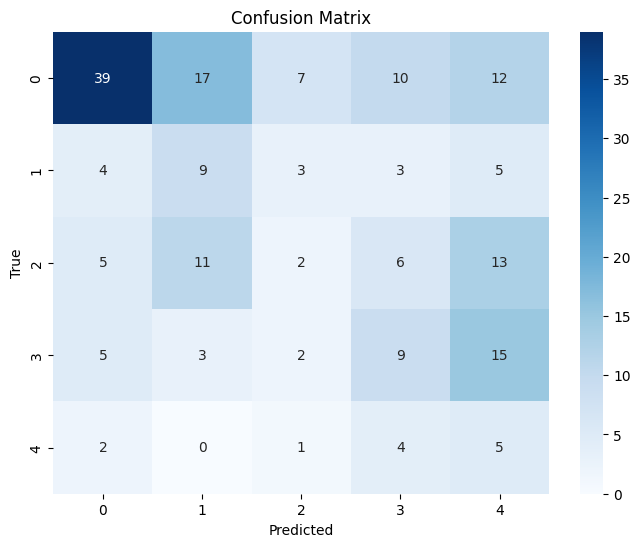

In [353]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [354]:
torch.save({
    "model_state_dict": model.state_dict(),
    "num_classes": 5,
}, "cnnnet.pth")


In [355]:

checkpoint = torch.load("cnnnet.pth", map_location=device, weights_only=False)

model = TinyCNN()

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()


TinyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [356]:
test_dataset = pickle.load(open('ift-3395-6390-kaggle-2-competition-fall-2025/test_data.pkl', 'rb'))
test_images = test_dataset['images']


test_transform = transforms.Compose([
    
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    
    transforms.Normalize(mean=IR_MEAN, std=IR_STD)
])

In [357]:


class TestPKLDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform
     
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]

        image = Image.fromarray(image.astype('uint8'))
        
        if self.transform:
            image = self.transform(image)
        return image


In [358]:
test_ds = TestPKLDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, pin_memory=True)
preds = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())

df = pd.DataFrame({

    "ID": np.arange(1, len(preds) + 1),
    "Label": preds
})

df.to_csv("IFT3395_YAPS_MCSV53.csv", index=False)

/Users/yamira.poldosilva/Documents/UDEM/A25/IFT3395/kaggle2/kaggle2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (64x8192 and 1152x128)